# Assignment 4: CNN and ResNet


We first import all we need

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset

import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.datasets as DS
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

torch.cuda.is_available()
device = torch.cuda.is_available()

In [2]:
data_file_path = r"C:\Users\pc\Desktop\1513project"
image_path =  r"C:\Users\pc\Desktop\1513project\noisy-images\noisy-images"
def load_data(data_file_path):
    train_df = pd.read_csv(data_file_path +'\\'+ 'train.csv')
    return train_df

train_df = load_data(data_file_path)

In [3]:
data_size = len(train_df)
print(data_size)

# remove all free gifts
train_df = train_df[train_df.category != 'Free Gifts']
data_size = len(train_df)
print(data_size)
train_df = train_df[((train_df['category'] != 'Topwear') )]
data_size = len(train_df)
print(data_size)
train_df = train_df[((train_df['category'] != 'Shoes') )]
data_size = len(train_df)
print(data_size)
categories = train_df.category.unique()
category_d = {k: v for v, k in enumerate(categories)}

# training data

train_df.replace(
    {'category': category_d}
    , inplace=True
)

# testing data


id_target = train_df[['id', 'category']].values

21627
21583
13877
10263


In [4]:
train_labels = id_target[:, 1]
train_id = id_target[:, 0]

In [5]:
transformer = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

class Image_Dataset(Dataset):

    def __init__(self, id_target, folder=image_path):
        self.id_target = id_target
        self.folder = folder
        self.transform = transformer
    def __len__(self):
        return len(self.id_target)

    def __getitem__(self, idx):
        img_name = self.folder + '\\'+str(id_target[idx][0]) + '.jpg'
        image = Image.open(img_name)
        result = self.transform(image)

        return result, self.id_target[idx][1]

In [6]:
train_image = Image_Dataset(id_target)

In [7]:

train_set, test_set = train_test_split(train_image, test_size=0.2, shuffle=True)

In [8]:
mat = torch.tensor([[0.1,0.3,0.5, 0.1],[0.3,0.1,0.5,0.1]]).float()
F.softmax(mat, dim=1)

tensor([[0.2122, 0.2591, 0.3165, 0.2122],
        [0.2591, 0.2122, 0.3165, 0.2122]])

In [9]:
mat.shape

torch.Size([2, 4])

### Task 2: Implementing the Test Loop

In [10]:
def test(model, loss_function, test_loader, device):
    # we first move our model to the configured device
    model = model.to(device = device)

    # we make sure we are not tracking gradient
    # gradient is used in training, we do not need it for test
    with torch.no_grad():
        risk = 0
        accuracy = 0

        # loop over test mini-batches
        for i, (images, labels) in enumerate(test_loader):
            # reshape labels to have the same form as output
            # make sure labels are of torch.float32 type
            # labels = labels.float()

            # move tensors to the configured device
            images = images.to(device = device)
            labels = labels.to(device = device)

            # forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            
            # compute the fraction of correctly predicted labels
            # correct_predict = torch.sum(labels- outputs).item()
            pred = outputs.max(1, keepdim=True)[1]
            correct = pred.eq(labels.view_as(pred)).sum().item()

            risk += loss.item()
            accuracy += correct/len(labels)

        # average test risk and accuracy over the whole test dataset
        test_risk = risk/len(test_loader)
        test_accuracy = accuracy/len(test_loader)

    return test_risk, test_accuracy

Now test your untrained model.

### Task 3: Implementing Training Loop

In [44]:
def train(model, device, num_epochs=500, batch_size=32, learning_rate=0.001, patience=5):
    # we first move our model to the configured device
    model = model.to(device = device)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    # set loss to binary CE
    loss_function = nn.CrossEntropyLoss()

    # Set optimizer with optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Initiate the values
    train_risk = []
    test_risk = []
    test_accuracy = []
    best_val_loss = float('inf')
    ending = num_epochs
    for epoch in range(num_epochs):
        # training risk in one epoch
        risk = 0

        # loop over training data
        for i, (images, labels) in enumerate(train_loader):
            model.train()
            # reshape labels to have the same form as output
            # make sure labels are of torch.float32 type
            # labels = labels.float()

            # move tensors to the configured device
            images = images.to(device = device)
            labels = labels.to(device = device)

            # forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # collect the training loss
            risk += loss.item()

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # use auto-grad (just 1 line)

            # one step of gradient descent
            optimizer.step()

        train_risk.append(risk/len(train_loader))
        # we can print a message every second epoch
        if (epoch+1) % 2 == 0:
            # test out model after update by the optimizer
            risk_epoch, accuracy_epoch = test(model, loss_function, test_loader, device)
            # Early stopping check
            if risk_epoch < best_val_loss:
                best_val_loss = risk_epoch
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1
                if no_improvement_counter >= patience:
                    print(f"No improvement in validation loss for {2*patience} epochs. Stopping training.")
                    ending = epoch + 1
                    break
            # collect losses and accuracy
            
            test_risk.append(risk_epoch)
            test_accuracy.append(accuracy_epoch)
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_risk[-1]}, Test Loss: {test_risk[-1]}, Test Accuracy: {test_accuracy[-1]}")

    # plot the losses
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("PlainCNN Loss")
    plt.plot([i+1 for i in range(ending )], train_risk, label="train")
    plt.plot([i+1 for i in range(0, ending-2, 2)], test_risk, label="validation")
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # plot the accuracy
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("PlainCNN Accuracy")
    plt.plot([i+1 for i in range(0, ending-2, 2)], test_accuracy)
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    return train_risk, train_risk, test_accuracy

In [12]:
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.name = "ANN"
        self.fc1 = nn.Linear(3*60*80, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 26)

    def forward(self, x):
        x = x.view(-1, 3*60*80)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
class PlainCNN(nn.Module):
    def __init__(self):
        super(PlainCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.relu5 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc7 = nn.Linear(64 * 17 * 12, 128)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(128, 26)

    def forward(self, x):
        h = self.conv1(x)
        h = self.relu1(h)
        h = self.conv2(h)
        h = self.relu2(h)
        h = self.pool3(h)
        h = self.conv4(h)
        h = self.relu4(h)
        h = self.conv5(h)
        h = self.relu5(h)
        h = self.pool6(h)
        h = h.view(-1, 64 * 17 * 12)  # Reshape for fully connected layer
        h = self.fc7(h)
        h = self.relu7(h)
        y = self.fc8(h)
        # return torch.squeeze(y)
        return y

In [13]:
if torch.has_cuda:
    device = "cuda"
elif torch.has_mps:
    device = "mps"
else:
    device = "cpu"
print(device)

cuda


C:\Users\pc\AppData\Local\Temp\ipykernel_15580\3980980500.py:1: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if torch.has_cuda:


Epoch [2/500], Train Loss: 2.887708641932561, Test Loss: 2.811782907037174, Test Accuracy: 0.27187500000000003
Epoch [4/500], Train Loss: 2.6530833831200233, Test Loss: 2.627721113317153, Test Accuracy: 0.30340073529411765
Epoch [6/500], Train Loss: 2.5110265988569993, Test Loss: 2.4988466150620403, Test Accuracy: 0.3139705882352941
Epoch [8/500], Train Loss: 2.3944926885458138, Test Loss: 2.4064472843618954, Test Accuracy: 0.3599264705882353
Epoch [10/500], Train Loss: 2.300960500423725, Test Loss: 2.3231842517852783, Test Accuracy: 0.41047794117647063
Epoch [12/500], Train Loss: 2.224352451471182, Test Loss: 2.197685445056242, Test Accuracy: 0.4597426470588235
Epoch [14/500], Train Loss: 2.1407423092768743, Test Loss: 2.187718026778277, Test Accuracy: 0.42812500000000003
Epoch [16/500], Train Loss: 2.0844440111747153, Test Loss: 2.0591365519691918, Test Accuracy: 0.475827205882353
Epoch [18/500], Train Loss: 2.028490746938265, Test Loss: 2.066086166045245, Test Accuracy: 0.4865808823

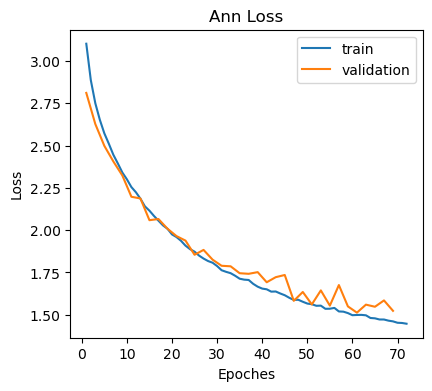

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


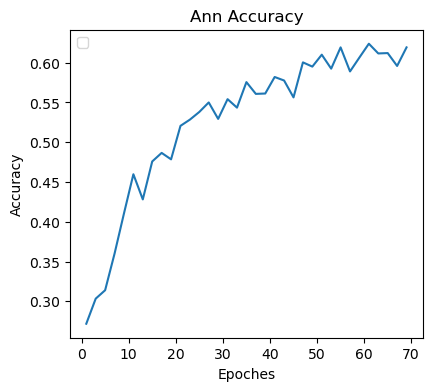

In [18]:
model = ANNClassifier()
best_result = train(model, device)

Epoch [2/500], Train Loss: 3.17690460876732, Test Loss: 3.074072632422814, Test Accuracy: 0.12884615384615383
Epoch [4/500], Train Loss: 2.7662663867965285, Test Loss: 2.6927453334514913, Test Accuracy: 0.24009615384615385
Epoch [6/500], Train Loss: 2.166350853118451, Test Loss: 2.1498629276569075, Test Accuracy: 0.38903846153846156
Epoch [8/500], Train Loss: 1.8274305307447678, Test Loss: 1.860210160108713, Test Accuracy: 0.4736538461538462
Epoch [10/500], Train Loss: 1.6773215553176077, Test Loss: 1.659416653559758, Test Accuracy: 0.5584615384615385
Epoch [12/500], Train Loss: 1.5825423591331749, Test Loss: 1.6724407764581533, Test Accuracy: 0.5561538461538461
Epoch [14/500], Train Loss: 1.520777726219786, Test Loss: 1.5913218397360582, Test Accuracy: 0.580576923076923
Epoch [16/500], Train Loss: 1.4740902653927932, Test Loss: 1.5960262518662673, Test Accuracy: 0.5707692307692308
Epoch [18/500], Train Loss: 1.4265145081954245, Test Loss: 1.6045533125217144, Test Accuracy: 0.561634615

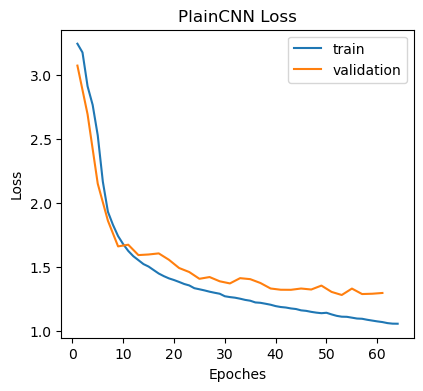

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


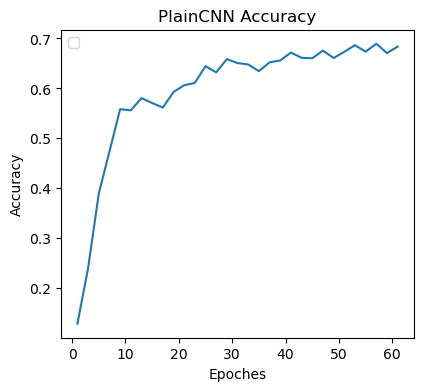

In [46]:
model = PlainCNN()

train_risk, train_risk, test_accuracy = train(model, device)

Epoch [2/100], Train Loss: 2.2240072580484243, Test Loss: 2.177020458614125, Test Accuracy: 0.4256433823529412
Epoch [4/100], Train Loss: 1.8363708569453312, Test Loss: 1.8461952980826883, Test Accuracy: 0.5040441176470588
Epoch [6/100], Train Loss: 1.6600953854047336, Test Loss: 1.853683029904085, Test Accuracy: 0.45707720588235295
Epoch [8/100], Train Loss: 1.5421228885650635, Test Loss: 1.6617666412802303, Test Accuracy: 0.5613051470588236
Epoch [10/100], Train Loss: 1.4609166163664598, Test Loss: 1.631776999024784, Test Accuracy: 0.5699448529411765
Epoch [12/100], Train Loss: 1.3910043257933395, Test Loss: 1.602048537310432, Test Accuracy: 0.5879595588235295
Epoch [14/100], Train Loss: 1.3494383041675275, Test Loss: 1.7395247291116154, Test Accuracy: 0.5222426470588236
Epoch [16/100], Train Loss: 1.309197998046875, Test Loss: 1.6655125898473404, Test Accuracy: 0.5499999999999999
Epoch [18/100], Train Loss: 1.2879967900422904, Test Loss: 1.9283257021623499, Test Accuracy: 0.47022058

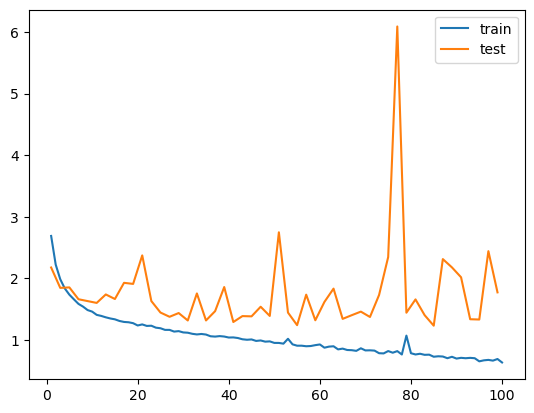

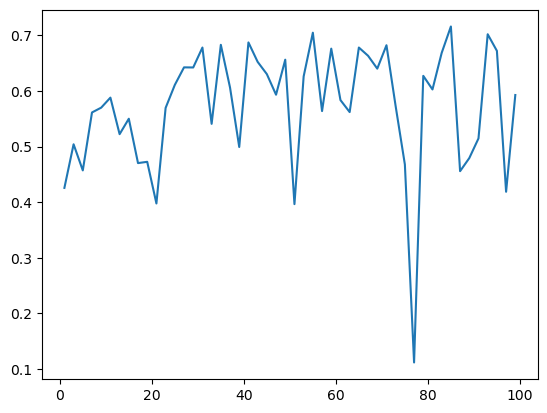

Epoch [2/100], Train Loss: 2.673481394262875, Test Loss: 2.595180797576904, Test Accuracy: 0.28234375
Epoch [4/100], Train Loss: 2.383398883482989, Test Loss: 2.4651482105255127, Test Accuracy: 0.224765625
Epoch [6/100], Train Loss: 2.2122254652135513, Test Loss: 2.39005765914917, Test Accuracy: 0.370859375
Epoch [8/100], Train Loss: 2.0747028449002434, Test Loss: 2.4138931751251222, Test Accuracy: 0.232421875
Epoch [10/100], Train Loss: 1.9602038579828598, Test Loss: 2.173403573036194, Test Accuracy: 0.45695312499999996
Epoch [12/100], Train Loss: 1.874676171471091, Test Loss: 1.8551296234130858, Test Accuracy: 0.49515624999999996
Epoch [14/100], Train Loss: 1.8586700874216415, Test Loss: 1.862684154510498, Test Accuracy: 0.489765625
Epoch [16/100], Train Loss: 1.7703541306888355, Test Loss: 2.071260905265808, Test Accuracy: 0.44601562499999997
Epoch [18/100], Train Loss: 1.6794068813323975, Test Loss: 1.972928762435913, Test Accuracy: 0.443671875
Epoch [20/100], Train Loss: 1.6524533

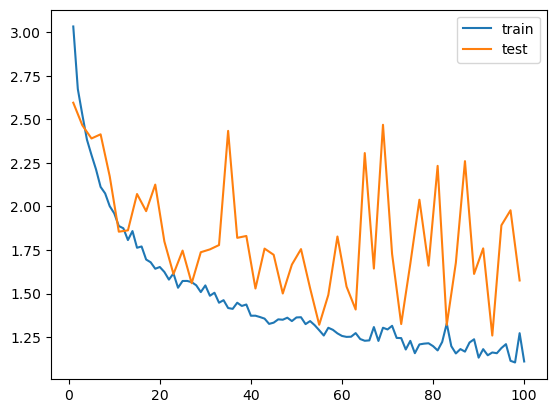

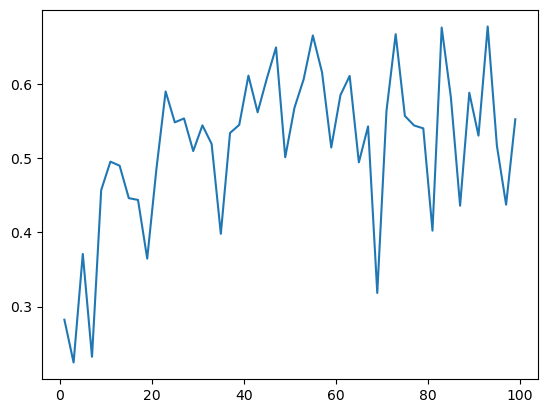

Epoch [2/100], Train Loss: 1.90653475218041, Test Loss: 1.8770575884616736, Test Accuracy: 0.499810606060606
Epoch [4/100], Train Loss: 1.5781832184902458, Test Loss: 1.9587493340174358, Test Accuracy: 0.43124999999999997
Epoch [6/100], Train Loss: 1.4379118685574495, Test Loss: 1.5244092905160151, Test Accuracy: 0.6052083333333333
Epoch [8/100], Train Loss: 1.3602002166038336, Test Loss: 1.5185043558929905, Test Accuracy: 0.6203598484848485
Epoch [10/100], Train Loss: 1.2941868587057719, Test Loss: 1.6619962128725918, Test Accuracy: 0.5505681818181818
Epoch [12/100], Train Loss: 1.2336483736370885, Test Loss: 1.408207320805752, Test Accuracy: 0.6487689393939394
Epoch [14/100], Train Loss: 1.1903387321982273, Test Loss: 1.6435282122005115, Test Accuracy: 0.5428977272727272
Epoch [16/100], Train Loss: 1.153480703516524, Test Loss: 1.3547240188627532, Test Accuracy: 0.6529356060606061
Epoch [18/100], Train Loss: 1.1197688367015632, Test Loss: 1.3088185389836628, Test Accuracy: 0.67471590

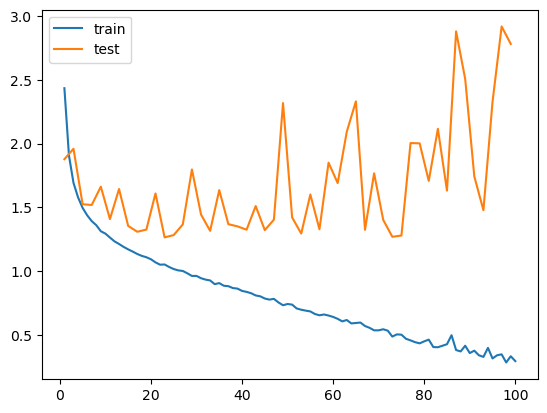

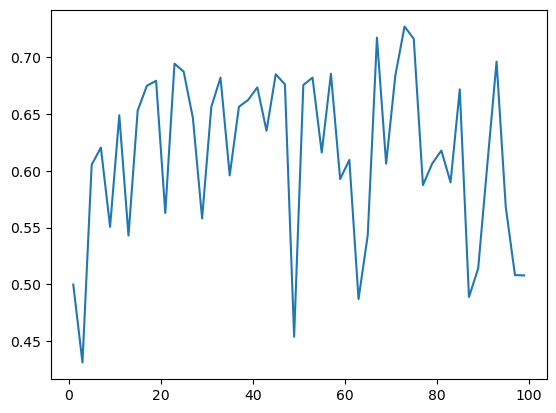

Epoch [2/100], Train Loss: 2.9079429222987248, Test Loss: 2.827827481662526, Test Accuracy: 0.22049632352941176
Epoch [4/100], Train Loss: 2.694954564021184, Test Loss: 2.6880979117225197, Test Accuracy: 0.26433823529411765
Epoch [6/100], Train Loss: 2.551619529724121, Test Loss: 2.5644531109753776, Test Accuracy: 0.2541360294117647
Epoch [8/100], Train Loss: 2.4381844447209287, Test Loss: 2.3962333482854508, Test Accuracy: 0.3579044117647059
Epoch [10/100], Train Loss: 2.338288824374859, Test Loss: 2.3379807191736557, Test Accuracy: 0.39880514705882353
Epoch [12/100], Train Loss: 2.2462152554438664, Test Loss: 2.255063533782959, Test Accuracy: 0.4141544117647059
Epoch [14/100], Train Loss: 2.168829032090994, Test Loss: 2.2196823709151325, Test Accuracy: 0.4276654411764706
Epoch [16/100], Train Loss: 2.10216892682589, Test Loss: 2.128674198599423, Test Accuracy: 0.4780330882352941
Epoch [18/100], Train Loss: 2.050046891432542, Test Loss: 2.071093811708338, Test Accuracy: 0.492555147058

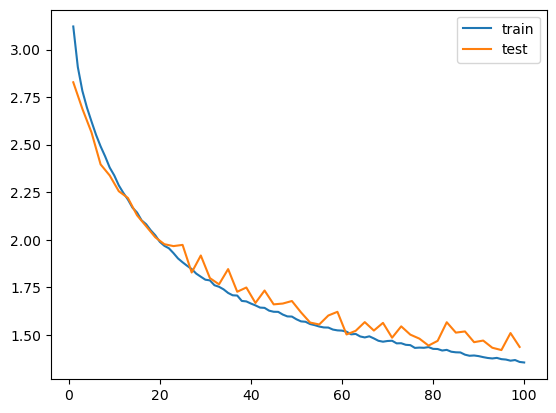

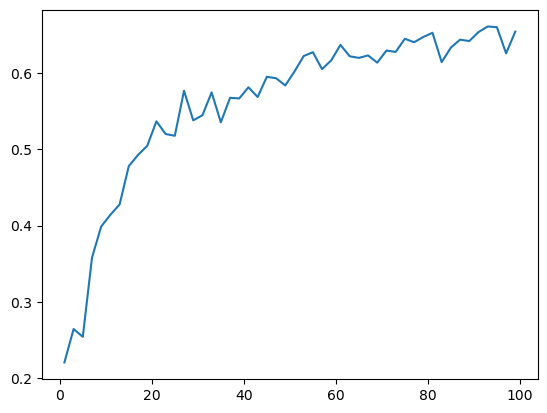

In [87]:
bs = [ 32, 128, 32, 128]
lr = [0.01, 0.01, 0.001, 0.001]

total_best_result = []
for i in range(len(bs)):
  model = ANNClassifier() ## or model = ANNclassifier()
  best_result = train(model, device, batch_size=bs[i], learning_rate=lr[i])
  total_best_result.append(best_result)

In [24]:


class ImprovedPlainCNN(nn.Module):
    def __init__(self):
        super(ImprovedPlainCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)  # 添加 Batch Normalization
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)  # 添加 Batch Normalization
        self.relu2 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)  # 添加 Dropout

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)  # 添加 Batch Normalization
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(64)  # 添加 Batch Normalization
        self.relu5 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)  # 添加 Dropout

        self.fc7 = nn.Linear(64 * 17 * 12, 128)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(128, 26)

    def forward(self, x):
        h = self.conv1(x)
        h = self.bn1(h)  # Batch Normalization
        h = self.relu1(h)
        h = self.conv2(h)
        h = self.bn2(h)  # Batch Normalization
        h = self.relu2(h)
        h = self.pool3(h)
        h = self.dropout1(h)  # Dropout
        h = self.conv4(h)
        h = self.bn3(h)  # Batch Normalization
        h = self.relu4(h)
        h = self.conv5(h)
        h = self.bn4(h)  # Batch Normalization
        h = self.relu5(h)
        h = self.pool6(h)
        h = self.dropout2(h)  # Dropout
        h = h.view(-1, 64 * 17 * 12)
        h = self.fc7(h)
        h = self.relu7(h)
        y = self.fc8(h)
        return y


In [70]:
class SkipCNN(nn.Module):
    def __init__(self):
        super(SkipCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6)
        self.relu5 = nn.ReLU()

        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc7 = self.fc7 = nn.Linear(64 * 17 * 12, 128)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(128, 26)

    def forward(self, x):
        # input to the residual unit
        h_in = self.relu1(self.conv1(x))
        h = self.relu2(self.conv2(h_in))
        h = self.relu3(self.conv3(h))
        h = h + h_in
        h = self.pool4(h)
        h = self.relu5(self.conv5(h))
        h = self.pool6(h)
        h = h.view(-1, 64 * 17 * 12)
        h = self.relu7(self.fc7(h))
        y = self.fc8(h)
        #y = F.softmax(y, dim=1)
        return y

Epoch [2/500], Train Loss: 2.3388220126812276, Test Loss: 2.23196273691514, Test Accuracy: 0.4155330882352941
Epoch [4/500], Train Loss: 1.880235378558819, Test Loss: 1.763033249798943, Test Accuracy: 0.5744485294117647
Epoch [6/500], Train Loss: 1.6437216648688684, Test Loss: 1.6838000241447897, Test Accuracy: 0.5701286764705882
Epoch [8/500], Train Loss: 1.5130344464228704, Test Loss: 1.4984295298071468, Test Accuracy: 0.6161764705882353
Epoch [10/500], Train Loss: 1.4424397688645583, Test Loss: 1.4496552172829122, Test Accuracy: 0.6423713235294117
Epoch [12/500], Train Loss: 1.3680841849400447, Test Loss: 1.3789128240417032, Test Accuracy: 0.635202205882353
Epoch [14/500], Train Loss: 1.3188979176374582, Test Loss: 1.373138995731578, Test Accuracy: 0.661672794117647
Epoch [16/500], Train Loss: 1.2751916885375976, Test Loss: 1.3328934767666984, Test Accuracy: 0.6623161764705883
Epoch [18/500], Train Loss: 1.2488042152844943, Test Loss: 1.261349380016327, Test Accuracy: 0.698988970588

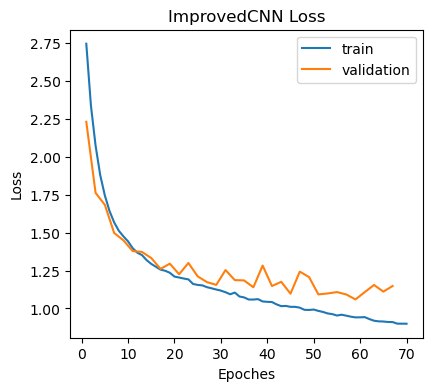

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


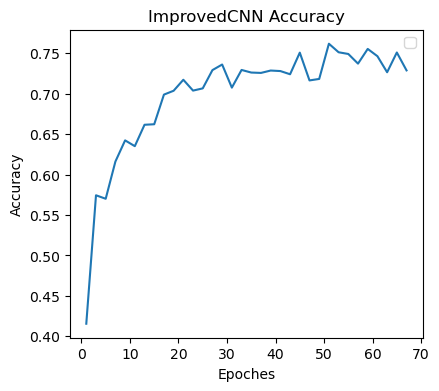

In [25]:
model = ImprovedPlainCNN()

train_risk, train_risk, test_accuracy = train(model, device)

In [ ]:
for i in range(10):
    continue

print(i)

9


# End of project, reference of dropout, batch normalization, skip layer below

### Task 4: Dropout and Batch Normalization
For this task you may copy class `myCNN` into this new class `myCNN_revised` and continue.

In [ ]:
class myCNN_revised(nn.Module):
    def __init__(self):
        super(myCNN_revised, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout2d(p=0.4)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout2d(p=0.4)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.relu5 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc7 = nn.Linear(64 * 5 * 5, 128)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.4)
        self.bn7 = nn.BatchNorm1d(128)

        self.fc8 = nn.Linear(128, 26)

    def forward(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu1(h)
        h = self.dropout1(h)

        h = self.conv2(h)
        h = self.relu2(h)
        h = self.pool3(h)
        h = self.conv4(h)
        h = self.bn4(h)
        h = self.relu4(h)
        h = self.dropout4(h)

        h = self.conv5(h)
        h = self.relu5(h)
        h = self.pool6(h)
        h = h.view(-1, 64 * 5 * 5)  # Reshape for fully connected layer
        h = self.fc7(h)
        h = self.bn7(h)
        h = self.relu7(h)
        h = self.dropout7(h)
        h = self.fc8(h)
        y = self.sigmoid8(h)
        return torch.squeeze(y)

Repeat the training now

### Task 1: Implement the Model
Pay attention to the skip connection. The rest is the same as the plain CNN.

### Task 3: Batch Normalization
Copy class `myResNet` into the class `myResNet_withBN` and apply the modifications.

In [ ]:
class myResNet_withBN(nn.Module):
    def __init__(self):
        super(myResNet_withBN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()

        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6)
        self.bn5 = nn.BatchNorm2d(64)
        self.relu5 = nn.ReLU()

        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc7 = self.fc7 = nn.Linear(64 * 5 * 5, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(128, 1)
        # self.bn8 = nn.BatchNorm1d(1)
        self.sigmoid8 = nn.Sigmoid()

    def forward(self, x):
        # input to the residual unit
        h_in = self.relu1(self.bn1(self.conv1(x)))
        h = self.relu2(self.bn2(self.conv2(h_in)))
        h = self.relu3(self.bn3(self.conv3(h)))
        h = h + h_in
        h = self.pool4(h)
        h = self.relu5(self.bn5(self.conv5(h)))
        h = self.pool6(h)
        h = h.view(-1, 64 * 5 * 5)
        h = self.relu7(self.bn7(self.fc7(h)))
        y = self.sigmoid8(self.fc8(h))
        return torch.squeeze(y)